In [1]:
%load_ext autoreload
%autoreload 2
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())
from config.settings import *

/home/kristian/mambaforge/envs/mitotem/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/kristian/mambaforge/envs/mitotem/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please

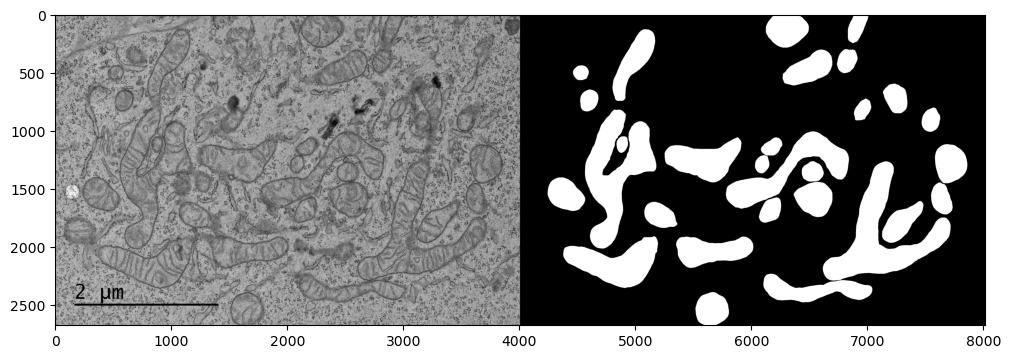

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from src.data.loaders import MitoSemsegDataset

dataset = MitoSemsegDataset(root=TRAIN_ROOT)
img, mask = dataset[81]

plt.figure(figsize=(12,6));
plt.imshow(np.concatenate([img, 255*mask], axis=1), cmap='gray');

In [11]:
from src.data.loaders import get_mean_and_std
mean, std = get_mean_and_std()
mean, std

(0.6551765203475952, 0.15311908721923828)

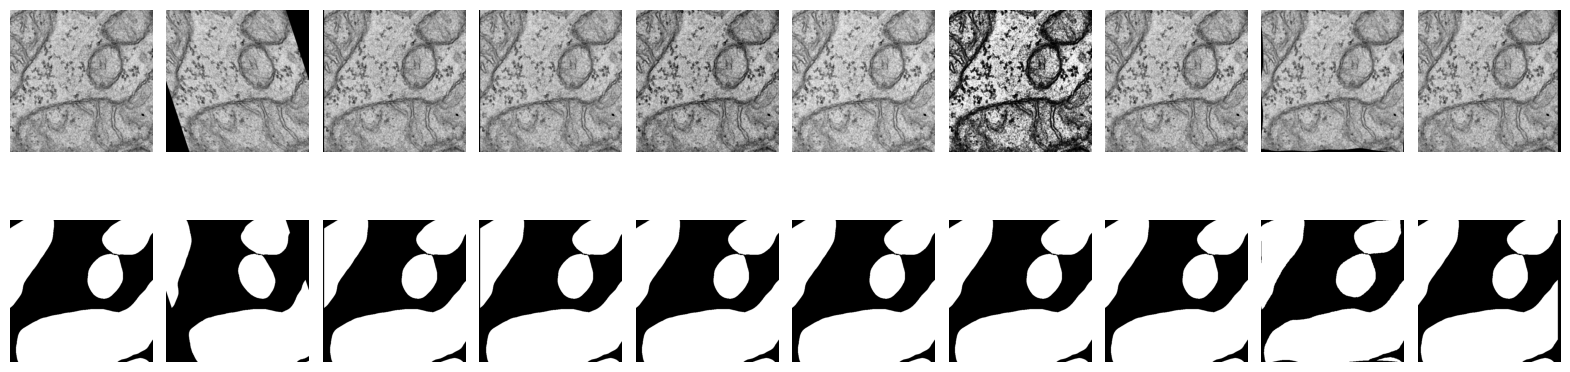

In [21]:
import torch
from src.data.loaders import TrivialAugmentWide
import torchvision.transforms.v2 as T

transforms = T.Compose([T.CenterCrop(500), TrivialAugmentWide(), T.ConvertDtype(), T.Normalize(mean=[0.6552], std=[0.1531])])

dataset = MitoSemsegDataset(root=TRAIN_ROOT, transforms=transforms)

top, left, h, w = 1100, 3500, 400, 400

m, n = 2, 10
augs = []
for _ in range(n):
    img, mask = dataset[81]
    augs.append((img, mask))

fig = plt.figure(figsize=(20,5))
gs = fig.add_gridspec(m, n, wspace=.1)
ax = gs.subplots()
for i in range(n):
    ax[0,i].axis('off'), ax[1,i].axis('off')
    ax[0,i].imshow(augs[i][0].squeeze(), cmap='gray')
    ax[1,i].imshow(augs[i][1].squeeze(), cmap='gray')

### Elastic warp test
"Especially random elastic deformations of the training samples seem to be the key concept to train a segmentation network with very few annotated images." <br>
Using torchvision's ElasticTransform, 0-1500 seems to be a nice range for magnitude (alpha) and 30 a nice value for smoothness (sigma)

In [10]:
import torchvision.transforms.v2 as T
import time
import ipywidgets
import cv2 as cv

def draw_grid(src, grid_shape, color=0, thickness=1):
    h, w, *_ = src.shape
    rows, cols = grid_shape
    dy, dx = h / rows, w / cols

    # draw vertical lines
    for x in np.linspace(start=dx, stop=w-dx, num=cols-1):
        x = int(round(x))
        cv.line(src, (x, 0), (x, h), color=color, thickness=thickness)

    # draw horizontal lines
    for y in np.linspace(start=dy, stop=h-dy, num=rows-1):
        y = int(round(y))
        cv.line(src, (0, y), (w, y), color=color, thickness=thickness)

    return src

@ipywidgets.interact(alpha=(0.,2000.0,10.),sigma=(0.,100.,1.))
def warp(alpha=1500.,sigma=30.0):
    dataset = MitoSemsegDataset(root=TRAIN_ROOT)
    img, mask = dataset[81]

    top, left, h, w = 1100, 2500, 1000, 1000
    crop = img[top:top+h,left:left+w]

    draw_grid(crop,(10,10))
    tf = T.Compose([T.ToTensor(), T.ElasticTransform(alpha,sigma)])
    t = time.time()
    warped = tf(crop)
    print(time.time()-t)

    plt.imshow(warped.squeeze(),cmap='gray')

interactive(children=(FloatSlider(value=1500.0, description='alpha', max=2000.0, step=10.0), FloatSlider(value…